# Sign Detection with VGG16

### Loading Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.models import Model
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras import layers
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Image Data Augmentation

In [2]:
# ImageDataGenerator
datagen = ImageDataGenerator(
    validation_split=0.2,
         rotation_range=10, # rotation
         width_shift_range=0.2, # horizontal shift
         height_shift_range=0.2, # vertical shift
         zoom_range=0.2, # zoom
         horizontal_flip=True, # horizontal flip
         brightness_range=[0.2,1.2]) # brightness

data_dir = "ISL-Original/Training"
test_datagen=ImageDataGenerator(validation_split=0.2)
train_ds = datagen.flow_from_directory(data_dir,
                                           class_mode = 'categorical',
                                           target_size = (150, 150),
                                           batch_size=64,
                                       subset='training',
                                           seed=46)
val_ds = test_datagen.flow_from_directory(data_dir,
                                     class_mode = 'categorical',
                                     target_size = (150, 150),
                                     batch_size=64,
                                          subset='validation',
                                     seed=46)

Found 8803 images belonging to 26 classes.
Found 2189 images belonging to 26 classes.


### Declare Metrics 

In [3]:
from tensorflow.keras import backend as K
def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    precision_f = precision(y_true, y_pred)
    recall_f = recall(y_true, y_pred)
    return 2*((precision_f*recall_f)/(precision_f+recall_f+K.epsilon()))

### Implement the Deep Learning Model - VGG16

In [4]:
vgg_base_model = VGG16(input_shape = (150, 150, 3), include_top = False, weights = "imagenet")
vgg_base_model.trainable = False

inputs = tf.keras.Input(shape=(150,150,3))

x = vgg_base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(26, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 26)                13338     
Total params: 14,728,026
Trainable params: 13,338
Non-trainable params: 14,714,688
_________________________________________________________________


In [6]:
#fit the model
#it will take some time to train
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics = ['accuracy',f1, precision,recall])
history = model.fit(train_ds, epochs =5, batch_size = 64,validation_data=val_ds)

Epoch 1/5
138/138 [==============================] - 1242s 9s/step - loss: 2.2632 - accuracy: 0.5908 - f1: 0.5643 - precision: 0.6468 - recall: 0.5042 - val_loss: 0.3618 - val_accuracy: 0.8977 - val_f1: 0.8963 - val_precision: 0.9025 - val_recall: 0.8903
Epoch 2/5
138/138 [==============================] - 1007s 7s/step - loss: 0.3187 - accuracy: 0.9199 - f1: 0.9069 - precision: 0.9457 - recall: 0.8718 - val_loss: 0.1932 - val_accuracy: 0.9447 - val_f1: 0.9461 - val_precision: 0.9476 - val_recall: 0.9446
Epoch 3/5
138/138 [==============================] - 1023s 7s/step - loss: 0.1796 - accuracy: 0.9600 - f1: 0.9511 - precision: 0.9717 - recall: 0.9316 - val_loss: 0.1039 - val_accuracy: 0.9694 - val_f1: 0.9705 - val_precision: 0.9713 - val_recall: 0.9696
Epoch 4/5
138/138 [==============================] - 1026s 7s/step - loss: 0.1326 - accuracy: 0.9713 - f1: 0.9663 - precision: 0.9798 - recall: 0.9534 - val_loss: 0.1364 - val_accuracy: 0.9612 - val_f1: 0.9605 - val_precision: 0.9607 -

### Learning Curves - Graph 

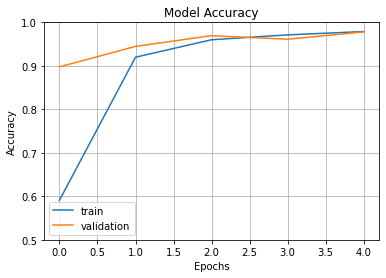

In [10]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.5,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

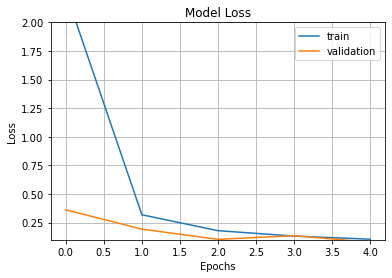

In [12]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0.1,ymax=2)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

### Evaluating the Model 

In [13]:
Y_pred = model.predict_generator(val_ds)
y_pred = np.argmax(Y_pred, axis=1)

Text(0.5, 33.0, 'Predicted label')

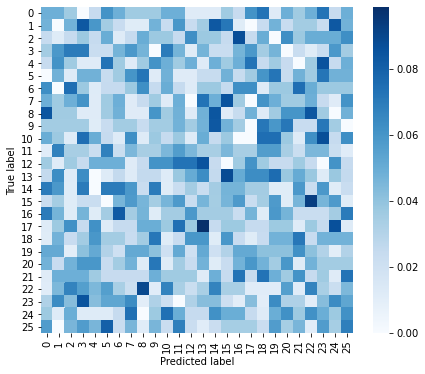

In [14]:
cf_mat = confusion_matrix(val_ds.classes, y_pred)
cf_mat_normalized = cf_mat.astype('float') / cf_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(7, 6))
sns.heatmap(cf_mat_normalized, cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [15]:
model.save('vgg16_signd.h5')

In [16]:
labels = val_ds.classes
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.05      0.05      0.05        82
           1       0.00      0.00      0.00        84
           2       0.03      0.03      0.03        80
           3       0.06      0.07      0.07        85
           4       0.01      0.01      0.01        82
           5       0.02      0.02      0.02        83
           6       0.03      0.03      0.03        80
           7       0.01      0.01      0.01        82
           8       0.01      0.01      0.01        83
           9       0.03      0.04      0.04        84
          10       0.03      0.03      0.03        80
          11       0.05      0.06      0.06        88
          12       0.09      0.07      0.08        82
          13       0.05      0.06      0.06        79
          14       0.04      0.04      0.04        85
          15       0.05      0.05      0.05        86
          16       0.02      0.02      0.02        85
          17       0.03    

['E']

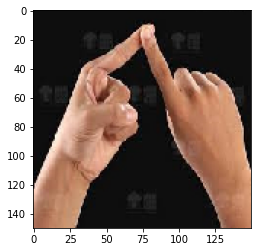

In [27]:
#Creating a dictionary to map each of the indexes to the corresponding number or letter
from keras.preprocessing import image
dict = {0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G",7:"H",8:"I",9:"J",10:"K",
        11:"L",12:"M",13:"N",14:"O",15:"P",16:"Q",17:"R",18:"S",19:"T",20:"U",21:"V",22:"W",23:"X",
        24:"Y",25:"Z"}


#Predicting images

img = image.load_img("sign_E.jpg", target_size=(150, 150))
x = image.img_to_array(img)
plt.imshow(img)
x = np.expand_dims(x, axis=0)

image = np.vstack([x])
classes = model.predict(image, batch_size=64)
label = [np.argmax(i) for i in classes]
pred_class=[dict[x] for x in label]
pred_class

In [18]:
loss, accuracy, f1_score, precision, recall = model.evaluate(val_ds, verbose=0)

In [28]:
print(f"Test Loss: ", loss)
print(f"Test Accuracy: ", accuracy)
print(f"Test Precision: ", precision)
print(f"Test Recall: ",recall)
print(f"Test F1 Score: ",f1_score)

Test Loss:  0.07887113094329834
Test Accuracy:  0.9780721664428711
Test Precision:  0.9785714149475098
Test Recall:  0.9785714149475098
Test F1 Score:  0.9785712957382202


In [21]:
print(f"Test Loss: ", round(loss*100, 3), '%')
print(f"Test Accuracy: ", round(accuracy*100, 3), '%')
print(f"Test Precision: ", round(precision*100, 3), '%')
print(f"Test Recall: ",round(recall*100, 3), '%')
print(f"Test F1 Score: ",round(f1_score*100, 3), '%')

Test Loss:  7.887 %
Test Accuracy:  97.807 %
Test Precision:  97.857 %
Test Recall:  97.857 %
Test F1 Score:  97.857 %
